In [2]:
from tqdm import tqdm
import time  # Added for simulating some code execution time

total_iterations = 30 * 50

# Create a tqdm progress bar
with tqdm(total=total_iterations, desc="Combined Progress") as pbar:
    for x in range(30):
        for y in range(50):
            # Simulate some code execution time
            time.sleep(0.01)
            # some code ...

            # Update the progress bar by one step
            pbar.update(1)

Combined Progress: 100%|██████████| 1500/1500 [00:16<00:00, 93.54it/s]


In [5]:
import matplotlib.patches as patches
import boto3
import json

import constants as c
from crop_functions import *
from analyze_book_name_functions import *

# Prepare Request

In [14]:
with open('credentials.json') as f:
    credentials = json.load(f)

aws_access_key_id = credentials['aws_access_key_id']
aws_secret_access_key = credentials['aws_secret_access_key']
rekognition = boto3.client(
    'rekognition',
    region_name='us-east-1',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)
client = vision.ImageAnnotatorClient()

# Prepare Confusion Matrix Functions

In [7]:
def ensure_string(value):
    if isinstance(value, str):
        return value
    else:
        return str(value)

def define_confusion_matrix(actual, predicted):
    TP = FP = FN = 0
    matched_actual = []
    actual_copy = actual.copy()
    fp_lst = []
    fn_lst = []

    print(f"Number of True Book Names: {len(actual)}")
    print(f"Number of Detected Book Name: {len(predicted)}")
    for p in predicted:
        match_found = False
        for a in actual:
            if ensure_string(a).lower() == ensure_string(p).lower():
                if a in actual_copy:
                    actual_copy.remove(a)
                    matched_actual.append(a)
                    TP += 1
                    match_found = True
                    break
                else:
                    continue

        if not match_found:
            FP += 1
            fp_lst.append(p)

    # Check for False Negatives
    matched_actual_copy = matched_actual.copy()
    for a in actual:
        if a not in matched_actual_copy:
            FN += 1
            fn_lst.append(a)
        else:
            matched_actual_copy.remove(a)


    print(f"{'Matched by both':<20} {TP:<20}")
    print(f"{'Only by OCR':<20} {FP:<20}")
    print(f"{'Only by Human':<20} {FN:<20}")
    print()

    return fp_lst, fn_lst, TP

# Prepare True Data

In [8]:
def collect_names(shelf: pd.DataFrame):
    names = []
    for index, row in shelf.iterrows():
        book_name = row['Book Name']
        author_name = row['Author Name']
        temp_name = ''
        if not pd.isna(book_name):
            temp_name += book_name
        if not pd.isna(author_name):
            temp_name += ' ' + author_name
        if temp_name != '':
            names.append(temp_name)
    splits = []
    for string in names:
        splits.extend(ensure_string(string).split())
    return splits, names

file_path1 = 'bookshelves_data.xlsx'
file_path2 = 'bookshelves_data_round2.xlsx'

all_sheets_df = pd.read_excel(file_path2, sheet_name=None)
# shelf_1 = all_sheets_df['Bookshelves_1']
# shelf_4 = all_sheets_df['Bookshelves_4']
# shelf_5 = all_sheets_df['Bookshelves_5']
shelf_6 = all_sheets_df['Bookshelves_6']
shelf_7 = all_sheets_df['Bookshelves_7']
shelf_8 = all_sheets_df['Bookshelves_8']
# actual_names_1_split, actual_names_1 = collect_names(shelf_1)
# actual_names_4_split, actual_names_4 = collect_names(shelf_4)
# actual_names_5_split, actual_names_5 = collect_names(shelf_5)
actual_names_6_split, actual_names_6 = collect_names(shelf_6)
actual_names_7_split, actual_names_7 = collect_names(shelf_7)
actual_names_8_split, actual_names_8 = collect_names(shelf_8)

# Show Text in Pics Functions

In [9]:
def get_rect(coord):
    return {
        'x': coord['Left'],
        'y': coord['Top'],
        'width': coord['Width'],
        'height': coord['Height']
    }

def get_text_data(text):
    coord = text.boundBox
    return get_rect(coord)

def draw_rectangle(rectangle, color='white'):
    rect = patches.Rectangle((rectangle['x'],
                              rectangle['y']),
                             rectangle['width'],
                             rectangle['height'],
                             linewidth=1,
                             edgecolor=color, facecolor='none')
    return rect

def plot_text_detected(im, df):
    if df is not None:
        all_text_rects = [draw_rectangle(get_text_data(annotation), color='blue')
                      for annotation in df.itertuples()]
    else:
        all_text_rects = []
    
    fix,ax = plt.subplots(figsize=(12, 8))
    ax.imshow(im)
    
    for rect in all_text_rects:
        ax.add_patch(rect)
    
    plt.show()

# Run Test

In [32]:
# img_paths = ['./pics/IMG_1548.JPG', './pics/IMG_1545.JPG', './pics/IMG_1544.JPG']
img_paths = ['./pics/IMG_7940.jpeg'] #, './pics/IMG_7941.jpeg', './pics/IMG_7942.jpeg']
actual_names = [[actual_names_6_split, actual_names_6]]
    #, [actual_names_7_split, actual_names_7], [actual_names_8_split, actual_names_8]]
cropped_pics = []
for idx, path in enumerate(img_paths):
    im, cropped_img = crop_image(path)
    cropped_pics.append((cropped_img, im))
    # for idx2, lst in enumerate(cropped_img):
    #     for idx3, image in enumerate(lst):
    #         plot_text_detected(image, None)

No need to be cropped


In [26]:
def collect_book_names(img, api, select_ocr, use_line):
    if select_ocr == 'google':
        words, lines = get_google_response(img, api)
        text = lines if use_line else words
        allText, text_df = google_extract_text_and_position(text, img)
    elif select_ocr == 'amazon':
        words, lines = get_amazon_response(img, api)
        text = lines if use_line else words
        allText, text_df = amazon_extract_text_and_position(text, img)
    else:
        print("=========================")
        print("Invalid API")
        print("=========================")
        return None, None

    text_df = analyze_text_location(text_df, img)
    return text_df

def get_data(img_paths, actual_names, cropped_pics, api, api_provider, useline):
    print('=========================================================')
    print(f'{api_provider.upper()} OCR with {"line" if useline else "word"}: \n')
    half_way_data = {}
    for idx, (crops, ori_img) in enumerate(cropped_pics):
        path = img_paths[idx]
        img_name = path.split("/")[-1]
    
        # predict_names = set()
        # detected_texts = set()
        half_way_data[idx] = {}
        for idx2, lst in enumerate(crops):
            half_way_data[idx][idx2] = {}
            for idx3, image in enumerate(lst):
                cv2.imwrite(f'./temp_pics/{img_name}_{idx2}_{idx3}.jpg', image)
                text_df = collect_book_names(image, api, api_provider, useline)
                half_way_data[idx][idx2][idx3] = text_df
                # predict_names.update(book_names)
                # for value in text_df.itertuples():
                #     detected_texts.add(value.txt)
    
                # plot_text_detected(image, text_df)
        # print(f"{img_paths[idx]} Detected Line Confusion Matrix:")
        # fp1, fn1 = define_confusion_matrix(actual_names[idx][0], list(detected_texts))
        # print(f"Detected but not in Actual: {fp}\n")
        # print(f"In Actual but not Detected: {fn}")
        # print(f"{img_paths[idx]} Book Name Confusion Matrix:")
        # fp2, fn2 = define_confusion_matrix(actual_names[idx][1], list(predict_names))
        # print(f"Detected but not in Actual: {fp}\n")
        # print(f"In Actual but not Detected: {fn}")
        # print('=========================================================')
    return half_way_data
        

In [27]:
# check_accuracy(client, 'google', True)
half_way_data = get_data(img_paths, actual_names, cropped_pics, client, 'google', False)
# check_accuracy(img_paths, actual_names, cropped_pics, rekognition, 'amazon', True)
# check_accuracy(img_paths, actual_names, cropped_pics, rekognition, 'amazon', False)

GOOGLE OCR with word: 


In [18]:
import re

def normalize(text):
    return re.sub(r'[^a-z0-9\s]', '', str(text).lower())


# Function to calculate match percentage
def calculate_match_percentage(book_author, string_list):
    # Normalize the book/author name
    normalized_book_author = set(normalize(book_author).split())
    # Normalize the strings in the string list
    normalized_string_list = [normalize(s) for s in string_list]

    # Calculate the number of matching words
    matches = sum(1 for word in normalized_string_list if word in normalized_book_author)
    detected_matches = sum(1 for word in normalized_book_author if word in normalized_string_list)

    # Calculate match percentage
    if len(normalized_book_author) == 0:  # Prevent division by zero
        return 0
    match_percentage1 = (matches / len(normalized_book_author)) * 100
    match_percentage2 = (detected_matches / len(normalized_string_list)) * 100
    return match_percentage1, match_percentage2


def highest_match(book_names, str_list):
    highest_match_percentages = [(-1, -1)] * len(book_names)  # Start with -1 to indicate no match
    highest_match_str = [-1] * len(book_names)
    names = [-1] * len(book_names)
    str_list_used = [False] * len(str_list)

    # Compare each book/author name with each string list
    for i in range(len(book_names)):

        book_author = book_names[i]
        for j, string_list in enumerate(str_list):
            if str_list_used[j]:
                continue

            match_percentage = calculate_match_percentage(book_author, string_list)
            if match_percentage[0] > highest_match_percentages[i][0]:
                highest_match_percentages[i] = match_percentage
                highest_match_str[i] = string_list
                names[i] = book_author

                if match_percentage[0] >= match_threshold and match_percentage[1] >= match_threshold:
                    str_list_used[j] = True

    highest_match_percentages = [percent for percent in highest_match_percentages if percent != -1]
    highest_match_str = [idx for idx in highest_match_str if idx != -1]
    names = [n for n in names if n != -1]
    combined_list = list(zip(names, highest_match_str, highest_match_percentages))
    return combined_list

In [28]:
def distance_relative_wh2(point1, point2, width, height, slope, xdt, ydt):
    x_diff = point2[0] - point1[0]
    y_diff = point2[1] - point1[1]
    if slope == 0:
        slope = 0.0001
    theta = math.atan(-1/slope)
    sin_theta = math.sin(theta)
    cos_theta = math.cos(theta)
    rotated_x_diff = x_diff * cos_theta + y_diff * sin_theta
    rotated_y_diff = y_diff * cos_theta - x_diff * sin_theta

    perpen_diff = rotated_x_diff / (width * xdt)
    parall_diff = rotated_y_diff / (height * ydt)

    dist = sqrt(perpen_diff ** 2 + parall_diff ** 2)
    # if rotated_y_diff > 0:
    #     return -dist
    return dist


def update_distance2(element2, element1, df_all, xdt, ydt):
    # Assuming width and height are known or calculated previously
    # You may need to adjust the logic to calculate or retrieve width and height
    point1 = element1[2]
    point2 = element2[2]
    t1 = df_all.iloc[element1[0]]
    t1_slope = t1['slopes']
    t1_direction = t1['direction']
    if "vertical" == t1_direction:
        slope = t1_slope[0]
    elif "horizontal" == t1_direction:
        slope = t1_slope[1]
    else:
        slope = 0
    return distance_relative_wh2(point1, point2, t1.width, t1.height, slope, xdt, ydt)


def combine_elements2(data_dict, df_all, xdt, ydt):
    keys_to_remove = set()
    data = data_dict.copy()
    for key1 in data:
        point1 = data[key1][0]
        for key2 in data:
            if key1 < key2 and key1 not in keys_to_remove:
                set1 = set([item[0] for item in data[key1]])
                set2 = set([item[0] for item in data[key2]])

                shared_elements = set1 & set2
                if shared_elements:
                    # Combine lists and update elements
                    # print(f"{key1}: {key2}")
                    combined_list = [item for item in data[key2] if item[0] not in [i[0] for i in data[key1]]]

                    # Update elements that are newly added from the smaller key's list
                    for index, item in enumerate(combined_list):
                        if item[0] not in shared_elements and item[0] != point1[0]:
                            # Update the 4th element using the update_distance function
                            # Assume point1, width, height, and slope are defined elsewhere
                            temp_lst = list(item)
                            updated_dist = update_distance2(item, point1, df_all, xdt, ydt)
                            if len(temp_lst) == 4:
                                temp_lst[3] = updated_dist
                            else:
                                temp_lst.append(updated_dist)
                            combined_list[index] = tuple(temp_lst)

                    combined_list = data[key1] + combined_list

                    # Deduplicate the combined list based on the first element of each tuple
                    unique_combined_list = []
                    seen = set()
                    for item in combined_list:
                        if item[0] not in seen:
                            unique_combined_list.append(item)
                            seen.add(item[0])

                    data[key1] = unique_combined_list
                    keys_to_remove.add(key2)

    # Remove keys
    for key in keys_to_remove:
        del data[key]

    return data


def group_related_text2(texts, xdt, ydt):
    related_text = {}
    for t1_idx, t1 in texts.iterrows():
        if t1['confidence'] <= CONFIDENCE_THRESHOLD:
            continue
        related_text[t1_idx] = []
        related_text[t1_idx].append((t1_idx, t1['txt'], t1.mid_point))
        for t2_idx, t2 in texts.iterrows():
            if t2['confidence'] <= CONFIDENCE_THRESHOLD or t1_idx == t2_idx:
                continue
            t1_slope = t1['slopes']
            t1_direction = t1['direction']
            t1_polygon = t1['vertices']
            v_slope = -200 if t1_slope[0] == 0 else -1/t1_slope[0]
            slope = min(abs(v_slope), abs(t1_slope[1]))
            if "vertical" == t1_direction:
                slope1 = -1 / slope if slope != 0 else -200
            elif "horizontal" == t1_direction:
                slope1 = slope
            else:
                print("===========================")
                print("l1 Invalid Direction")
                print("===========================")
                break
            distance = distance_relative_wh2(t1.mid_point, t2.mid_point, t1.width, t1.height, slope1, xdt, ydt)
            # inter_points = check_points(t2_polygon, slope1, p1, p2, img)
            if distance < 1: # or inter_points >= 2:
                content = (t2_idx, t2['txt'], t2.mid_point, distance)
                if content not in related_text[t1_idx]:
                    related_text[t1_idx].append(content)
    return related_text


def remove_duplicates2(original_data):
    data = original_data.copy()
    duplicate_data_key = []
    k1_duplicate = False

    for k1, value_list in data.items():
        k1_words = [item[1] for item in value_list]
        for k2, value_list2 in data.items():
            if k2 <= k1:
                continue
            k2_words = [item[1] for item in value_list2]

            set2 = set(k2_words)
            set1 = set(k1_words)
            if set2.issubset(set1):
                duplicate_data_key.append(k2)
            elif set1.issubset(set2):
                duplicate_data_key.append(k1)
                break

    for k in duplicate_data_key:
        data.pop(k, None)

    return data

match_threshold = 80

def group_text(filtered_data, text_df, xdt, ydt):
    data = combine_elements2(filtered_data, text_df, xdt, ydt)
    name_lst = [[e[1] for e in v] for k, v in data.items()]
    return name_lst


def test_hyperparameter(xdt, ydt):
    text_dict = {}
    tp_list = []
    actual_name = [[actual_names_6_split, actual_names_6]]#, [actual_names_7_split, actual_names_7], [actual_names_8_split, actual_names_8]]
    for k1, v1 in half_way_data.items():
        text_dict[k1] = pd.DataFrame()
        detected_texts = []
        total_true_match = 0
        total_false_neg = len(actual_name[k1][1])
        total_false_pos = 0
        total_positive = len(actual_name[k1][1])
        for k2, v2 in v1.items():
            for k3, v3 in v2.items():
                text_df = v3
                related_text = group_related_text2(text_df, xdt, ydt)
                filtered_data = remove_duplicates2(related_text)
                book_names = group_text(filtered_data, text_df, xdt, ydt)
                for value in text_df.itertuples():
                    detected_texts.append(value.txt)
                if len(text_df) > 0:
                    text_df['crop_idx'] = [(k2, k3)] * len(text_df)
                    text_df['Left'] = text_df['boundBox'].apply(lambda x: x['Left'])
                    text_df['Top'] = text_df['boundBox'].apply(lambda x: x['Top'])
                    df_sorted = text_df.sort_values(by=['Left', 'Top'])
                    text_dict[k1] = pd.concat([text_dict[k1], df_sorted], ignore_index=True)

                    hm_lst = highest_match(actual_name[k1][1], book_names)
                    temp_book_names = actual_name[k1][1].copy()
                    temp_hm_lst = hm_lst.copy()
                    temp_grouped_names = book_names.copy()
                    for hm in hm_lst:
                        # print(hm)
                        if hm[0] in temp_book_names and hm[2][0] >= match_threshold and hm[2][1] >= match_threshold:
                            if hm[1] in temp_grouped_names:
                                temp_book_names.remove(hm[0])
                                temp_grouped_names.remove(hm[1])
                                temp_hm_lst.remove(hm)
                    true_match = len(actual_name[k1][1]) - len(temp_book_names)
                    actual_name[k1][1] = temp_book_names
                    false_positive = len(temp_grouped_names)
                    total_true_match += true_match
                    total_false_neg -= true_match
                    total_false_pos += false_positive
    
        # print(f"{img_paths[k1]} Book Name Group Larger than {match_threshold}%:")
        # print(f"{'Matched by both':<20} {total_true_match:<20}")
        # print(f"{'Only by OCR':<20} {total_false_pos:<20}")
        # print(f"{'Only by Human':<20} {total_false_neg:<20}")
        # print('=========================================================')
        tp_list.append(total_true_match)
    return tp_list, text_dict

# tp_lst, txt_dict = test_hyperparameter(0.5, 2)

In [38]:
from tqdm import tqdm

lst = []
threshold_lst = []
txt_dicts = []
for xt in tqdm(range(8, 21), desc='Processing xt'):
    xt = xt / 10
    for yt in tqdm(range(2, 11), desc='Processing yt'):
        yt = yt / 2
        tp_lst, txt_dict = test_hyperparameter(xt, yt)
        lst.append(tp_lst)
        txt_dicts.append(txt_dict)
        threshold_lst.append((xt, yt))

# import concurrent.futures
# 
# def process_parameters(xt, yt):
#     xt = xt / 10
#     yt = yt / 2
#     tp_lst, txt_dict = test_hyperparameter(xt, yt)
#     return tp_lst, txt_dict, (xt, yt)
# 
# # Prepare input parameters for processing
# parameters = [(xt, yt) for xt in range(1, 20) for yt in range(2, 16)]
# 
# # Using ThreadPoolExecutor to parallelize the process
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     results = list(tqdm(executor.map(lambda p: process_parameters(*p), parameters), total=len(parameters)))
# 
# # Unpacking results
# lst, txt_dicts, threshold_lst = zip(*results)

Processing xt: 100%|██████████| 13/13 [1:25:17<00:00, 393.69s/it]


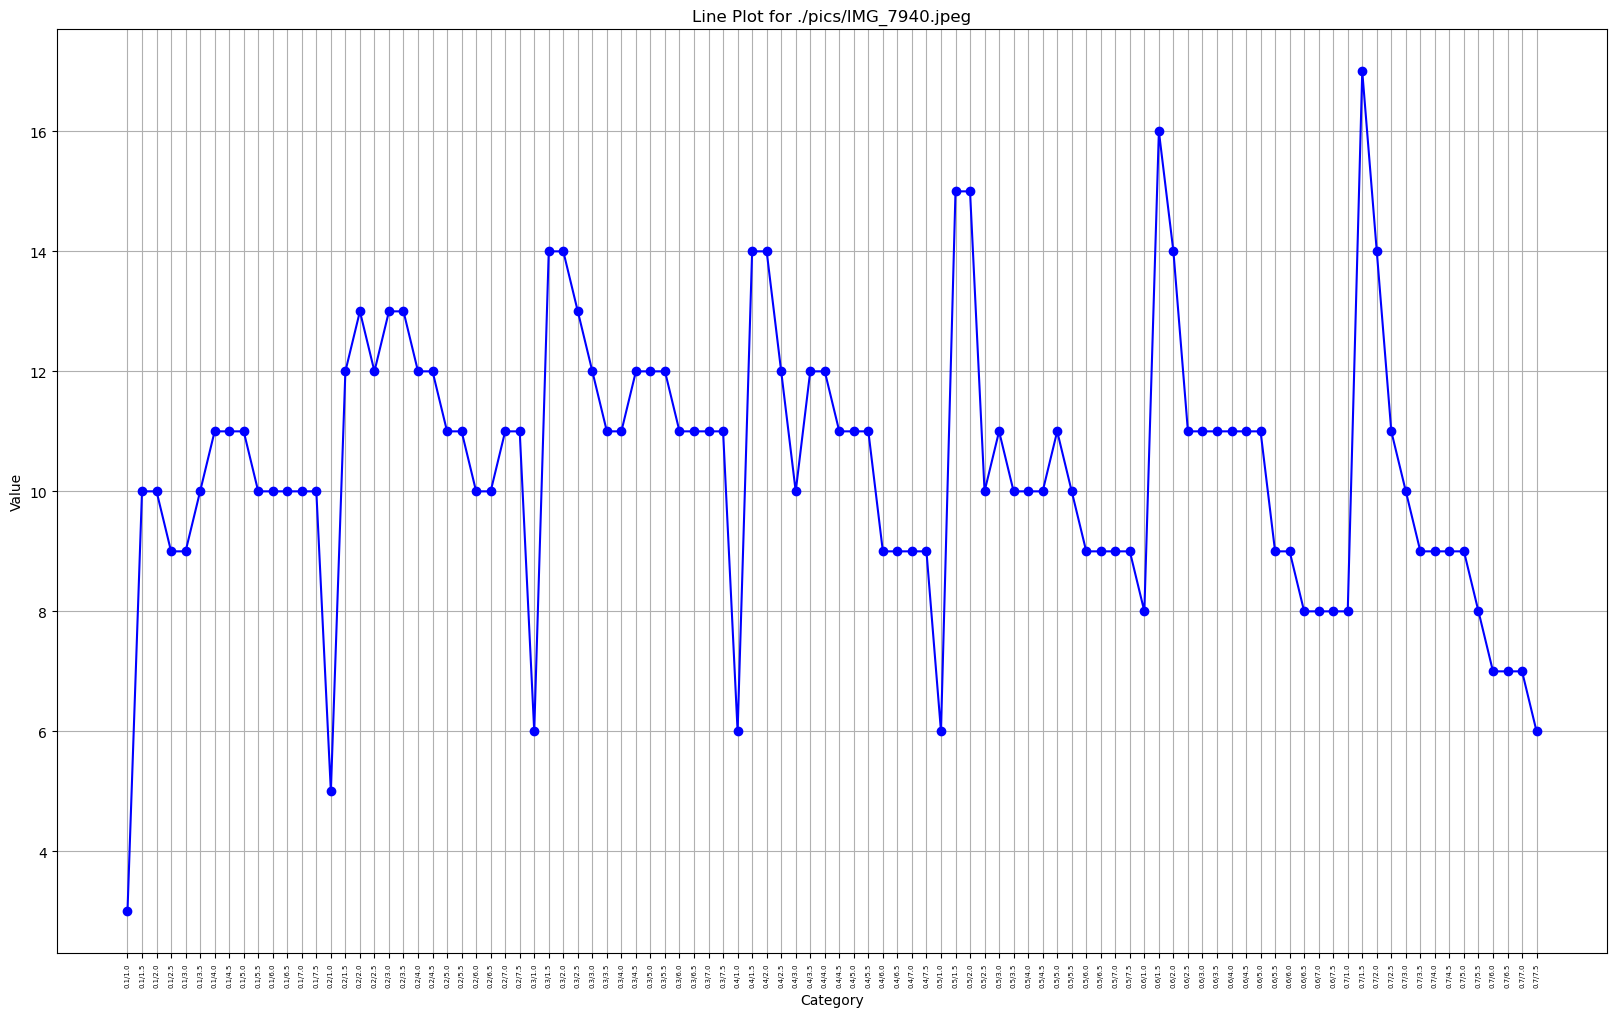

In [35]:
def plot_tp(np_arr, img_name, formatted_labels):
    plt.figure(figsize=(20, 12))
    plt.plot(np_arr, marker='o', linestyle='-', color='b')
    plt.title(f'Line Plot for {img_name}')
    plt.xlabel('Category')
    plt.ylabel('Value')
    plt.xticks(ticks=range(len(formatted_labels)), labels=formatted_labels, rotation=90, fontsize=5)
    plt.grid(True)
    plt.show()

np_arr = np.array(lst)
formatted_labels = [f'{tup[0]}/{tup[1]}' for tup in threshold_lst]

for i in range(len(img_paths)):
    element_np = np_arr[:, i]
    plot_tp(element_np, img_paths[i], formatted_labels)
    

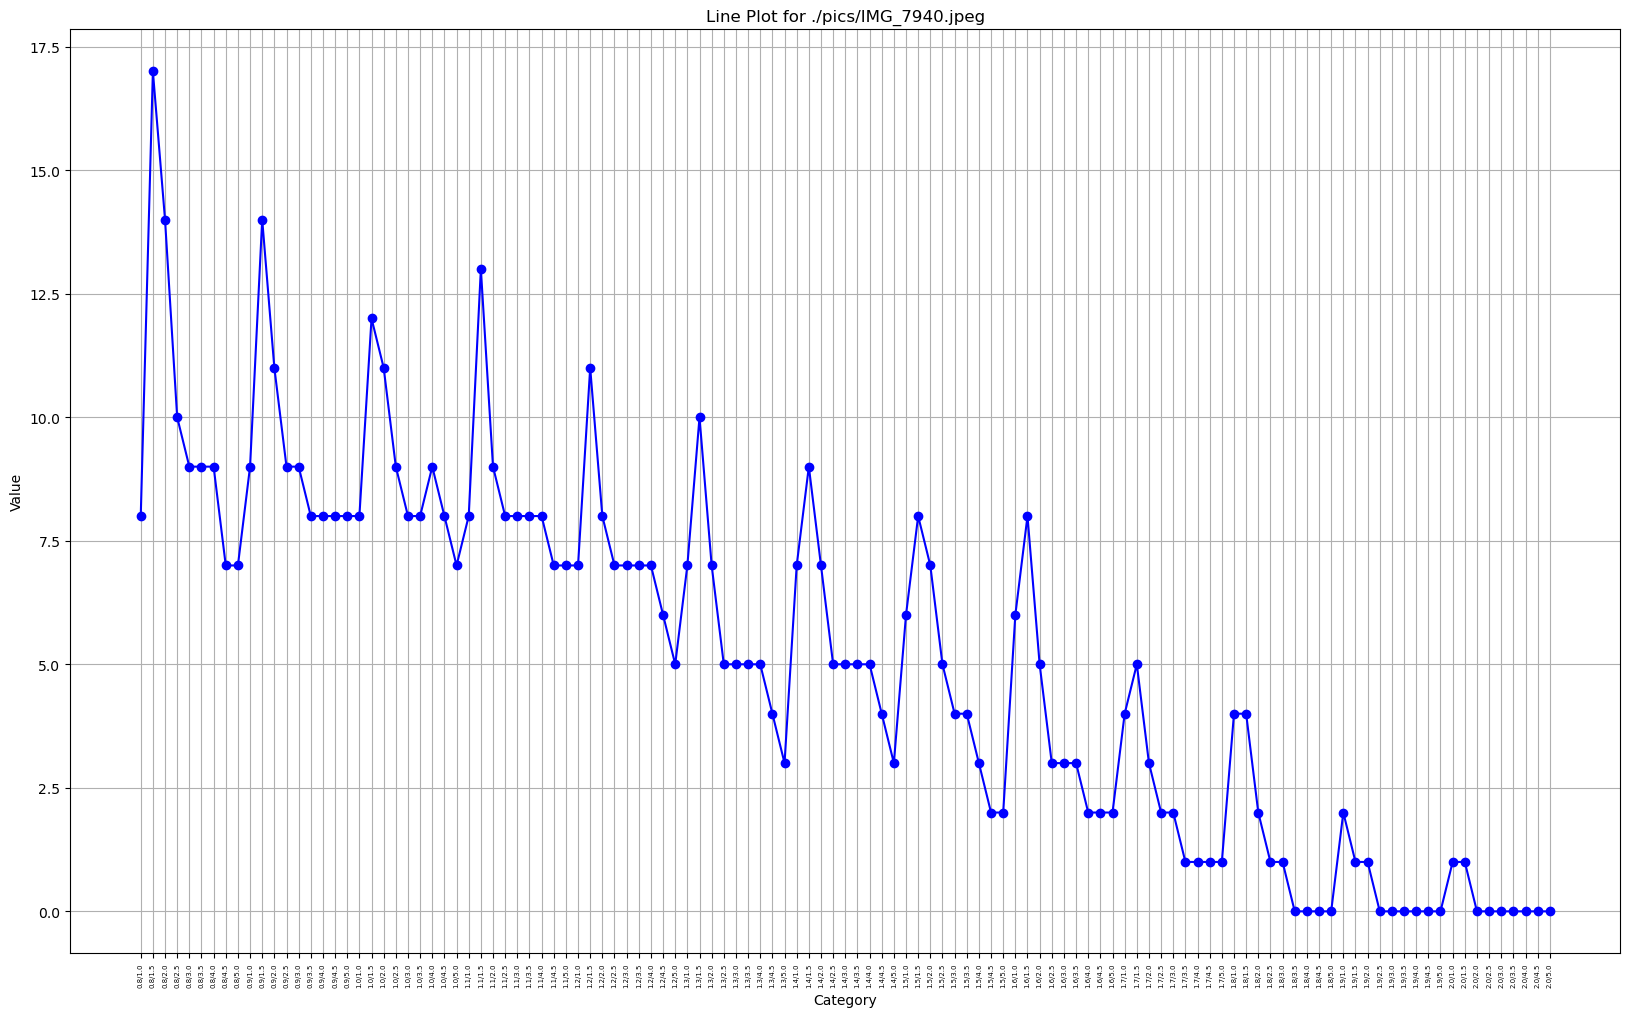

In [39]:
def plot_tp(np_arr, img_name, formatted_labels):
    plt.figure(figsize=(20, 12))
    plt.plot(np_arr, marker='o', linestyle='-', color='b')
    plt.title(f'Line Plot for {img_name}')
    plt.xlabel('Category')
    plt.ylabel('Value')
    plt.xticks(ticks=range(len(formatted_labels)), labels=formatted_labels, rotation=90, fontsize=5)
    plt.grid(True)
    plt.show()

np_arr = np.array(lst)
formatted_labels = [f'{tup[0]}/{tup[1]}' for tup in threshold_lst]

for i in range(len(img_paths)):
    element_np = np_arr[:, i]
    plot_tp(element_np, img_paths[i], formatted_labels)

1. Metrics
2. Choices of OCR
    1. Text
    2. Lines
    3. Objects
3. Text Relating
    1. Distance
    2. Horizontal distance
    3. Weighted Distance
4. Text Grouping
    1. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tp(np_arr, img_name, formatted_labels, segment_idx):
    plt.figure(figsize=(20, 12))
    plt.plot(np_arr, marker='o', linestyle='-', color='b')
    plt.title(f'Line Plot for {img_name} - Part {segment_idx+1}')
    plt.xlabel('Category')
    plt.ylabel('Value')

    # Adjust the ticks to only include the relevant segment
    segment_length = len(formatted_labels) // 3
    start_idx = segment_idx * segment_length
    end_idx = (segment_idx + 1) * segment_length if segment_idx < 2 else len(formatted_labels)

    plt.xticks(ticks=range(start_idx, end_idx), labels=formatted_labels[start_idx:end_idx], rotation=90, fontsize=5)
    plt.grid(True)
    plt.show()

# Assuming `np_arr` is a numpy array and `formatted_labels` is a list of labels
# And `threshold_lst` is defined somewhere in your code
# Example: threshold_lst = [(1, 'A'), (2, 'B'), ...]

# Splitting data and labels into 3 segments
for i in range(len(img_paths)):
    for segment_idx in range(3):
        segment_length = np_arr.shape[0] // 3
        start_idx = segment_idx * segment_length
        end_idx = (segment_idx + 1) * segment_length if segment_idx < 2 else np_arr.shape[0]

        # Extract the segment of the numpy array for the current image
        element_np = np_arr[start_idx:end_idx, i]

        # Plot each segment
        plot_tp(element_np, img_paths[i], formatted_labels, segment_idx)

NameError: name 'img_paths' is not defined

In [37]:
len(actual_names_6)

37

# Collect Book Names in Each Cropped Image

In [ ]:
# import time
# start_time = time.time()
# book_names = []
# for lst in cropped_img:
#     for img in lst:
#         lst = collect_book_names(img, True)
#         book_names.append(lst)
# end_time = time.time()
# 
# duration = end_time - start_time
# print(f"Time Used {duration} seconds")

# start_time = time.time()
# item_lst = []
# for idx, lst in enumerate(book_names):
#     print(f'=============== {idx} =================')
#     items = request_book_info(lst)
#     item_lst.append(items)
# 
# end_time = time.time()
# 
# duration = end_time - start_time
# print(f"\nTime Used {duration} seconds")

# Get Response

In [ ]:
# path = './temp_pics/IMG_1548.JPG_0_0.jpg'
# 
# im = np.array(Image.open(path), dtype=np.uint8)
# 
# texts, full_text = get_ocr_json(im)
# response_text = get_amazon_response(im, rekognition)

In [ ]:
greys = []
lines = []
# for idx, path in enumerate(img_paths):
path = img_paths[0]
img, thresh, resize_rate = get_image_and_grey(path)
image_height, image_width = thresh.shape
min_line_height = image_height * LINE_HEIGHT_PERCENT
min_line_width = image_width * LINE_WIDTH_PERCENT
min_rows = round(min_line_height)
min_cols = round(min_line_width)
print(min_rows)
print(min_cols)
_, color_lines = check_color_area(thresh, min_rows, min_cols)
print(check_shelf_divider(color_lines, thresh.shape))
greys.append(thresh)
lines.append(color_lines)

cropped_img = []
min_height = resize_rate/DEFAULT_RESIZE_RATE/LINE_HEIGHT_PERCENT * 2
color_area = []

for loc in color_lines:
    original_area = calculate_original_area(loc[0], loc[1], loc[0] + min_rows, loc[1] + min_cols, 1/resize_rate)
    color_area.append(original_area)

remain_parts = get_remain_parts(img, color_area, min_height)
horizontal_parts = cut_image_horizontally(img, remain_parts)

for part in horizontal_parts:
    vertical_parts = cut_image_vertically(part)
    cropped_img.append(vertical_parts)

In [ ]:
img= cropped_img[0][0]
words, lines = get_google_response(img, client)
text = words
allText, text_df = google_extract_text_and_position(text, img)
text_df = analyze_text_location(text_df, img)
text_df

In [ ]:
img2 = img[0:1000, 1500:img.shape[1]]
plt.imshow(img2)
plt.axis('off')
plt.show()

In [ ]:
# pat = './temp_pics/IMG_1548.JPG_0_0.jpg'
# img = cv2.imread(pat)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def distance_relative_wh(point1, point2, width, height, slope):
    x_diff = point2[0] - point1[0]
    y_diff = point2[1] - point1[1]
    theta = math.atan(-1/slope)
    sin = math.sin(theta)
    cos = math.cos(theta)
    perpen_diff = (x_diff*cos + y_diff*sin) / (width * xdt)
    parall_diff = (y_diff*cos - x_diff*sin) / (height * ydt)
    return sqrt(perpen_diff ** 2 + parall_diff ** 2)


mask = np.zeros_like(img2)
ref_point = text_df.iloc[8]
mid_point = (ref_point.mid_point[0] - 1500, ref_point.mid_point[1])

for y in range(img2.shape[0]):
    for x in range(img2.shape[1]):
        distance = distance_relative_wh(mid_point, (x, y), ref_point.width, ref_point.height, ref_point.slopes[0])
        if distance < 1:
            mask[y, x] = [255, 0, 0]  # Set the mask to blue (in RGB) for pixels that pass the distance function

result = cv2.addWeighted(img2, 0.7, mask, 0.3, 0)

plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.axis('off')
plt.show()

In [ ]:
fix,ax = plt.subplots(figsize=(12, 8))

ax.imshow(img)
height, width = img.shape[:2]
num_points = 9999

ref_point = text_df.iloc[88]

x_coords = np.random.randint(0, width, size=num_points)
y_coords = np.random.randint(0, height, size=num_points)

for x, y in zip(x_coords, y_coords):
    distance = distance_relative_wh(ref_point.mid_point, (x, y), ref_point.width, ref_point.height, ref_point.slopes[0])
    color = 'blue' if distance < 1 else 'red'
    ax.scatter(x, y, color=color, s= 2)
plt.axis('off')
plt.show()

In [ ]:
for lst in cropped_img:
    for img in lst:
        plot_text_detected(img, None)

In [ ]:
lines

In [ ]:
greys[2]